In [1]:
# Automatically reload changes to external code
%load_ext autoreload
%autoreload 2

In this assignment, you will solve a classic control problem - CartPole using policy gradient methods.

First, you will implement the "vanilla" policy gradient method, i.e., a method that repeatedly computes **unbiased** estimates $\hat{g}$ of $\nabla_{\theta} E[\sum_t r_t]$ and takes gradient ascent steps $\theta \rightarrow \theta + \epsilon \hat{g}$ so as to increase the total rewards collected in each episode. To make sure our code can solve multiple MDPs with different policy parameterizations, provided code follows an OOP manner and represents MDP and Policy as classes.

The following code constructs an instance of the MDP using OpenAI gym.

In [2]:
import gym
import tensorflow as tf
import numpy as np
from policy_gradient import util
from policy_gradient.policy import CategoricalPolicy
from policy_gradient.baselines.linear_feature_baseline import LinearFeatureBaseline
import matplotlib.pyplot as plt

np.random.seed(0)
tf.set_random_seed(0)

# CartPole-v0 is a MDP with finite state and action space. 
# In this environment, A pendulum is attached by an un-actuated joint to a cart, 
# and the goal is to prevent it from falling over. You can apply a force of +1 or -1 to the cart.
# A reward of +1 is provided for every timestep that the pendulum remains upright. 
# To visualize CartPole-v0, please see https://gym.openai.com/envs/CartPole-v0

env = gym.make('CartPole-v0')

[2016-10-15 21:57:09,076] Making new env: CartPole-v0


## Problem 1: construct a neural network to represent policy

Make sure you know how to construct neural network using tensorflow.

1. Open **homework2/policy_gradient/policy.py**.
2. Follow the instruction of Problem 1.

## Problem 2: compute the surrogate loss

If there are $N$ episodes in an iteration, then for $i$ th episode we define $R_t^i = \sum_{{t^′}=t}^T \gamma^{{t^′}-t}r(s_{t^′}, a_{t^′})$ as the accumulated discounted rewards from timestep $t$ to the end of that episode, where $\gamma$ is the discount rate.

The pseudocode for the REINFORCE algorithm is as below:

1. Initialize policy $\pi$ with parameter $\theta_1$.
2. For iteration $k = 1, 2, ...$:
    * Sample N episodes $\tau_1, \tau_2, ..., \tau_N$ under the current policy $\theta_k$, where $\tau_i =(s_i^t,a_i^t,R_i^t)_{t=0}^{T−1}$. Note that the last state is dropped since no action is taken after observing the last state.
    * Compute the empirical policy gradient using formula: $$\hat{g} = E_{\pi_\theta}[\nabla_{\theta} log\pi_\theta(a_t^i | s_t^i) R_t^i]$$
    * Take a gradient step: $\theta_{k+1} = \theta_k + \epsilon \hat{g}$.
    
    
Note that we can transform the policy gradient formula as

$$\hat{g} = \nabla_{\theta} \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) R_t^i)$$

and $L(\theta) = \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) R_t^i)$ is called the surrogate loss. 

We can first construct the computation graph for $L(\theta)$, and then take its gradient as the empirical policy gradient.


1. Open **homework2/policy_gradient/policy.py**.
2. Follow the instruction of Problem 2.

In [3]:
sess = tf.Session()

# Construct a neural network to represent policy which maps observed state to action. 
in_dim = util.flatten_space(env.observation_space)
out_dim = util.flatten_space(env.action_space)
hidden_dim = 8

opt = tf.train.AdamOptimizer(learning_rate=0.01)
policy = CategoricalPolicy(in_dim, out_dim, hidden_dim, opt, sess)

sess.run(tf.initialize_all_variables())

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# Problem 3

Implement a function that computes the accumulated discounted rewards of each timestep _t_ from _t_ to the end of the episode.

For example:

```python
rewards = [1, 1, 1]
discount_rate = 0.99
util.discount_cumsum(rewards, discount_rate)
```

should return:

`array([ 2.9701,  1.99  ,  1.    ])`

1. Open **homework/policy_gradient/util.py**.
2. Implement the commented function.

In [4]:
rewards = np.array([1, 1, 1])
discount_rate = 0.99
util.discount_cumsum(rewards, discount_rate)

array([ 2.9701,  1.99  ,  1.    ])

# Problem 4

Use baseline to reduce the variance of our gradient estimate.

1. Fill in the function `process_paths` of class `PolicyOptimizer` below.

In [5]:
class PolicyOptimizer(object):
    def __init__(self, env, policy, baseline, n_iter, n_episode, path_length,
        discount_rate=.99):

        self.policy = policy
        self.baseline = baseline
        self.env = env
        self.n_iter = n_iter
        self.n_episode = n_episode
        self.path_length = path_length
        self.discount_rate = discount_rate

    def sample_path(self):
        obs = []
        actions = []
        rewards = []
        ob = self.env.reset()

        for _ in range(self.path_length):
            a = self.policy.act(ob.reshape(1, -1))
            next_ob, r, done, _ = self.env.step(a)
            obs.append(ob)
            actions.append(a)
            rewards.append(r)
            ob = next_ob
            if done:
                break

        return dict(
            observations=np.array(obs),
            actions=np.array(actions),
            rewards=np.array(rewards),
        )

    def process_paths(self, paths):
        for p in paths:
            if self.baseline != None:
                b = self.baseline.predict(p)
            else:
                b = 0
            
            # `p["rewards"]` is a matrix contains the rewards of each timestep in a sample path
            r = util.discount_cumsum(p["rewards"], self.discount_rate)
            
            """
            Problem 4:

            1. Variable `b` is the reward predicted by our baseline
            2. Use it to reduce variance and then assign the result to the variable `a`

            Sample solution should be only 1 line.
            """
            # YOUR CODE HERE >>>>>>
            # a = ???
            a = r-b
            # <<<<<<<<

            p["returns"] = r
            p["baselines"] = b
            p["advantages"] = (a - a.mean()) / (a.std() + 1e-8) # normalize
            #p["advantages"] = a

        obs = np.concatenate([ p["observations"] for p in paths ])
        actions = np.concatenate([ p["actions"] for p in paths ])
        rewards = np.concatenate([ p["rewards"] for p in paths ])
        advantages = np.concatenate([ p["advantages"] for p in paths ])

        return dict(
            observations=obs,
            actions=actions,
            rewards=rewards,
            advantages=advantages,
        )

    def train(self):
        for i in range(1, self.n_iter + 1):
            paths = []
            for _ in range(self.n_episode):
                paths.append(self.sample_path())
            data = self.process_paths(paths)
            loss = self.policy.train(data["observations"], data["actions"], data["advantages"])
            avg_return = np.mean([sum(p["rewards"]) for p in paths])
            std_num=np.std([data["advantages"]])
            print("Iteration {}: Average Return = {}, standard deviation = {}".format(i, avg_return, std_num))
            iter_num.append(i)
            avg.append(avg_return)
            std.append(std_num)
            
            # CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials.
            if avg_return >= 195:
                print("Solve at {} iterations, which equals {} episodes.".format(i, i*100))
                break

            if self.baseline != None:
                self.baseline.fit(paths)

In [6]:
n_iter = 200
n_episode = 100
path_length = 200
discount_rate = 0.99
#baseline = LinearFeatureBaseline(env.spec)
baseline = None

po = PolicyOptimizer(env, policy, baseline, n_iter, n_episode, path_length,
                     discount_rate)

# Store result for plot purpose
iter_num = []
avg = []
std = []
# Train the policy optimizer
po.train()


Iteration 1: Average Return = 16.3, standard deviation = 0.999999997688
Iteration 2: Average Return = 19.24, standard deviation = 0.999999998014
Iteration 3: Average Return = 18.1, standard deviation = 0.9999999979
Iteration 4: Average Return = 19.02, standard deviation = 0.999999997993
Iteration 5: Average Return = 20.41, standard deviation = 0.999999998116
Iteration 6: Average Return = 22.27, standard deviation = 0.999999998257
Iteration 7: Average Return = 21.07, standard deviation = 0.999999998171
Iteration 8: Average Return = 27.45, standard deviation = 0.999999998551
Iteration 9: Average Return = 26.68, standard deviation = 0.999999998514
Iteration 10: Average Return = 28.76, standard deviation = 0.999999998608
Iteration 11: Average Return = 27.66, standard deviation = 0.99999999856
Iteration 12: Average Return = 29.33, standard deviation = 0.999999998632
Iteration 13: Average Return = 36.47, standard deviation = 0.99999999886
Iteration 14: Average Return = 34.94, standard deviat

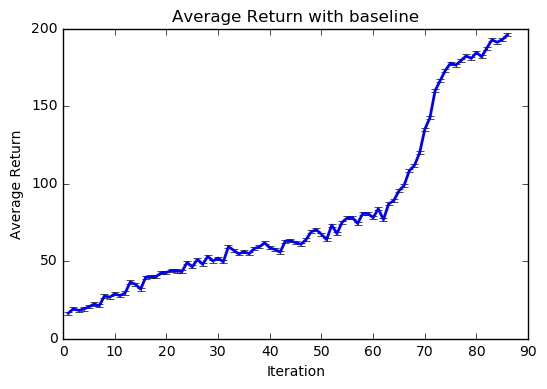

In [7]:
# Display figures to visualize average return and standard deviation
plt.title('Average Return with baseline')
plt.xlabel('Iteration')
plt.ylabel('Average Return')
plt.errorbar(iter_num, avg, yerr=std, color='b', linewidth=2, ecolor='k', elinewidth=0.5)
plt.show()

# Verify your solutions

if you solve the problems 1~4 correctly, your will solve CartPole with roughly ~ 80 iterations.

# Problem 5
Replacing line 

`baseline = LinearFeatureBaseline(env.spec)` 

with 

`baseline = None`

can remove the baseline.

Modify the code to compare the variance and performance before and after adding baseline.
Then, write a report about your findings. (with figures is better)

The following two images are pre-trained policy: 


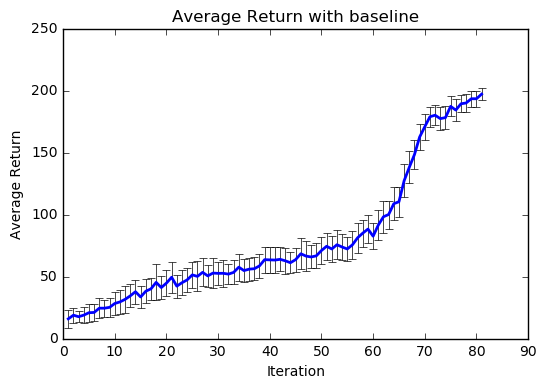

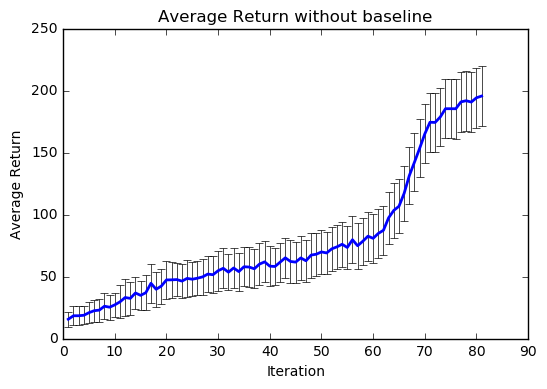

In [8]:
from IPython.display import display, Image
print("===========================================")
print("The following two images are pre-trained policy: ")
print("===========================================")
display(Image(filename="Average_return_with_baseline.png"), Image(filename="Average_return_without_baseline.png"))

上兩圖中的藍色線為Average Return值，而黑色線則表示Stardard Deviation範圍。

上圖是有在Policy Gradient中加入Baseline，而下圖則無，可以看到Standar Deviation值具有明顯差異，換算則Variance的話，有加入Baseline大約可以減少Variance約300～400左右，而在Variance值減少的情況下，原本可預期減少iteration數，在實驗中也曾測到Iteration數減少約10～20，但是因為每次執行的結果都不同，所以這裡給的數值只是大概值。

# Problem 6

In function process_paths of class `PolicyOptimizer`, why we need to normalize the advantages? i.e., what's the usage of this line:

`p["advantages"] = (a - a.mean()) / (a.std() + 1e-8)`

Include the answer in your report.

針對Advantage進行Normalization的話能夠穩定Rewards中的variance大小的影響，進一步讓Iteration數趨於穩定，原預期此一步驟可讓Gradient趨於穩定，然而經多次實驗後卻發現Iteration數量不減反增，加入Normalization僅能讓加入Baseline的因素影響減少而已，因此判定Normalization可讓Training過程穩定。